In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
import importlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import csbdeep


from csbdeep.utils import _raise, Path, axes_check_and_normalize,axes_dict, move_image_axes, move_channel_for_backend, backend_channels_last
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import matplotlib.pyplot as plt
from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
import matplotlib.pyplot as plt
import os
import sys
import random
import warnings
from csbdeep.utils import Path, normalize
import numpy as np
import pandas as pd
from externalmodels.unet import *
from csbdeep.io import load_training_data
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from csbdeep.utils import axes_dict, plot_some, plot_history
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.objectives import categorical_crossentropy
import tensorflow as tf

Using TensorFlow backend.


In [2]:
(X,Y),(X_val, Y_val), axes = load_training_data('/data/u934/service_imagerie/v_kapoor/CurieTrainingDatasets/Raw_Datasets/JesusFilaments/SingleChannelUnetFilamentSegmentation.npz',validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]
IMG_HEIGHT = X.shape[1]
IMG_WIDTH = X.shape[2]
IMG_CHANNELS = X.shape[c]
print(IMG_HEIGHT , IMG_WIDTH, IMG_CHANNELS )
print(X_val.shape)


number of training images:	 75600
number of validation images:	 8400
image size (2D):		 (64, 64)
axes:				 SYXC
channels in / out:		 1 / 1
64 64 1
(8400, 64, 64, 1)


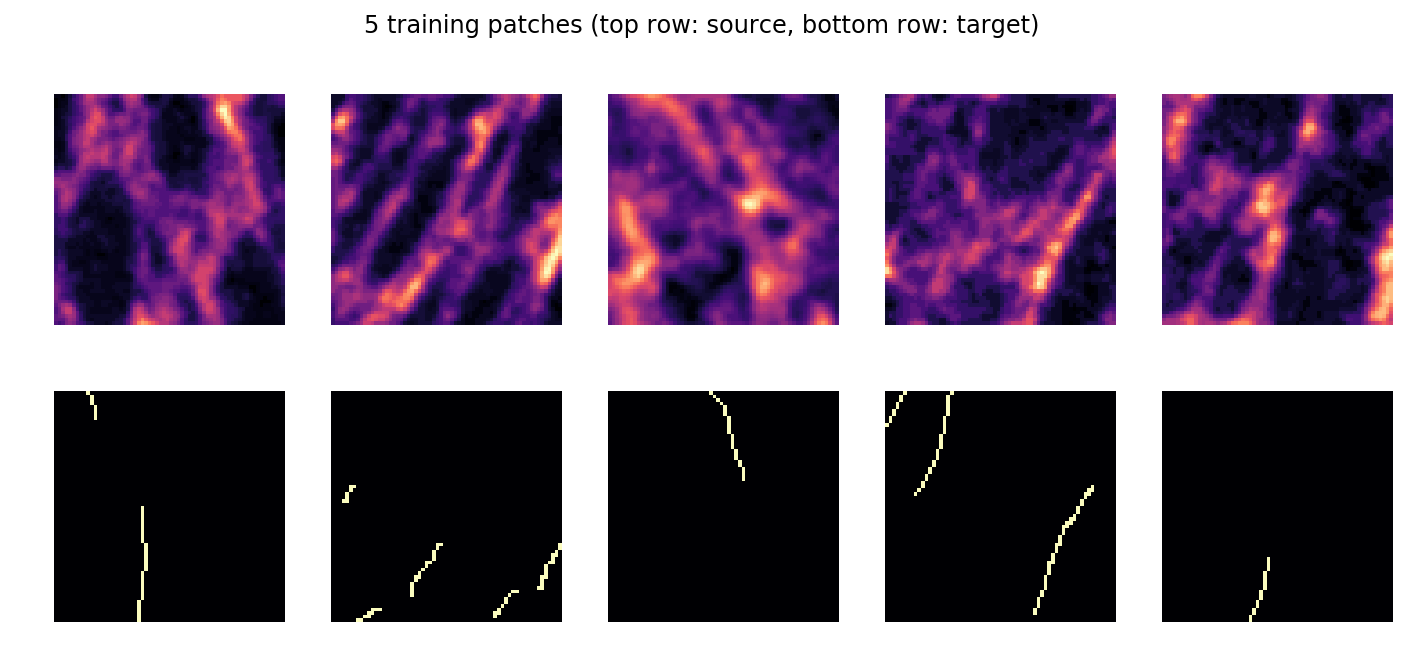

In [3]:
plt.figure(figsize=(12,5))
plot_some(X[:5],Y[:5])

plt.suptitle('5 training patches (top row: source, bottom row: target)');

In [4]:
config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=150,train_epochs = 400,unet_n_depth = 2, train_learning_rate = 0.02,train_batch_size = 32, unet_residual = True)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=32, train_checkpoint='weights_best.h5', train_epochs=400, train_learning_rate=0.02, train_loss='mae', train_reduce_lr={'patience': 10, 'factor': 0.5}, train_steps_per_epoch=150, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 2,
 'probabilistic': False,
 'train_batch_size': 32,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 400,
 'train_learning_rate': 0.02,
 'train_loss': 'mae',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_steps_per_epoch': 150,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, 1),
 'unet_kern_size': 5,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 32,
 'unet_residual': True}

In [5]:
model = CARE(config, 'JesusFilamentSingleChannelUNet', basedir='/data/u934/service_imagerie/v_kapoor/CurieDeepLearningModels/')

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/models/care_standard.py:99: UserWarning: output path for model already exists, files may be overwritten: /data/u934/service_imagerie/v_kapoor/CurieDeepLearningModels/JesusFilamentSingleChannelUNet
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [ ]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/400
150/150 [==============================] - 27s 183ms/step - loss: 251896990251918295040.0000 - mse: inf - mae: 251896991542011953152.0000 - val_loss: 257229603501548601344.0000 - val_mse: inf - val_mae: 257229606584369774592.0000
Epoch 2/400
150/150 [==============================] - 25s 169ms/step - loss: 254829245031927480320.0000 - mse: inf - mae: 254829247025708531712.0000 - val_loss: 257229603501548601344.0000 - val_mse: inf - val_mae: 257229606584369774592.0000
Epoch 3/400
150/150 [==============================] - 25s 169ms/step - loss: 260899257595942404096.0000 - mse: inf - mae: 260899259120598515712.0000 - val_loss: 257229603501548601344.0000 - val_mse: inf - val_mae: 257229606584369774592.0000
Epoch 4/400
150/150 [==============================] - 26s 170ms/step - loss: 256105265395474104320.0000 - mse: inf - mae: 256105267037411442688.0000 - val_loss: 257229603501548601344.0000 - val_mse: inf - val_mae: 257229606584369774592.0000
Epoch 5/400
150/150 [===========

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

In [ ]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');
   